# DS_7331 Machine Learning - Lab 3 - Group 4

# User-Item Collaborative Filtering - Amazon Electronic Product Reviews

### Paticia Attah<br> Linda Eliasen

In [116]:
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from collections import defaultdict
import os
from surprise.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## BUSINESS UNDERSTANDING 1

Recommender systems are among the most powerful machine learning systems that online retailers implement in order to enhance customer experience, create engagement and  drive sales; all with the ultimate goal of increasing revenue.  The results of these systems are all around us and often appear as "Frequently Bought Together", "Recommended for You", and "Customers who bought this item also bought".

The goal is to develop a user based collaborative filtering system based on historical user-item interaction in order to develop a recommender model.  Collaborative filtering takes into account the interaction between users and items to come up with relevant recommendations.  It identifies similar users, determines how similar they are to each other and then recommend other products based on these similarities.  Simply put, it is a technique used to predict the items that Customer A might like on the basis of ratings given to that item by the other customers who have rated other products in a similar fashion to Customer A.  

The assumption is that the customers who agreed in the past tend to also agree in the future. In terms of user preference, our dataset relies on explicit ratings (ratings provided on a sliding scale such as 1 - 5). This is the most direct feedback from customers indicating how much they like an item.

We will investigate memory and model based algorithms.  Model optimization will be evaluated based on RMSE and MAE. It is also very important to measure how the model is performing to achieve the objective of making good recommendations.  Decision support metrics employed to understand how well the model performs are Precision, Recall and F1 Score.  Combined, these metrics help us understand how meaningful the model's predictions are when recommending products to the customer. We will go into these metrics in more detail in the relevent sections.

The dataset for this lab consists of electronic product ratings from Amazon customers.  It is publicly available at:

https://nijianmo.github.io/amazon/index.html#subsets.



## DATA UNDERSTANDING 1

#### DATA MEANING & TYPE

Bringing in the data

In [157]:
df1 = pd.read_csv('ratings_Electronics.csv', names=['userId', 'productId','Rating','timestamp'])

#Dropping the Timestamp column as it is not needed 
df1.drop(['timestamp'], axis=1,inplace=True)

df1.head(10)

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
5,A1QGNMC6O1VW39,0511189877,5.0
6,A3J3BRHTDRFJ2G,0511189877,2.0
7,A2TY0BTJOTENPG,0511189877,5.0
8,A34ATBPOK6HCHY,0511189877,5.0
9,A89DO69P0XZ27,0511189877,5.0


In [4]:
df1.shape

(7824482, 3)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [6]:
#summary statistics

dfssc = pd.DataFrame([df1.Rating]).T
dfssc.describe()

,Rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


#### DATA QUALITY

 As this is Amazon data based on "stars" given to products, there are no rating outliers in the dataset.  All of them fall between 1 and 5. 

In [7]:
# minimum and maximum ratings

print('Minimum rating is: %d' %(df1.Rating.min()))
print('Maximum rating is: %d' %(df1.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


There isn't any duplicate data

There are no missing values.  To eliminate cases where one rater is disproportionately impacting a product's overall rating, we do not want duplicates in the dataset.  We will run through and drop any duplicates.  We can see that there were no duplicates as the shape of the dataset did not change. 

In [8]:
#Check for missing values

print('Number of missing values across columns: \n',df1.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
dtype: int64


In [120]:
df1 = df1.drop_duplicates()

In [121]:
df1.shape

(7824482, 3)

### DATA UNDERSTANDING 2

The dataset includes ratings for approximately 476,000 electronic products from 4 Million customers. 

In [134]:
print("Total data ")
print("-"*50)
print("\nTotal no of Ratings :",df1.shape[0])
print("Total No of Users   :", len(np.unique(df1.userId)))
print("Total No of Products  :", len(np.unique(df1.productId)))

Total data 
--------------------------------------------------

Total no of Ratings : 7824482
Total No of Users   : 4201696
Total No of Products  : 476002


Product ratings range from 1 through 5, with 5 being the highest rating.  As reflected in the charts below, the ratings are not normally distributed. The majority of the ratings given (~75%) were favorable, being either a 4 or 5.  This may not be unusual for the product category as electronics tend to have a higher price point than other consumer goods and customers conduct more research prior to making the purchase. This may also be indicative of the fact that Amazon does a good job of vetting products that are sold via their site. 

Of interest is that ratings of 1 were more numerous than ratings of 2 or 3 indicating that when a product did not live up to expecations, customers voiced their opinion.

In [132]:
rating_counts = pd.DataFrame(df1['Rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,5.0,4347541
1,4.0,1485781
2,1.0,901765
3,3.0,633073
4,2.0,456322


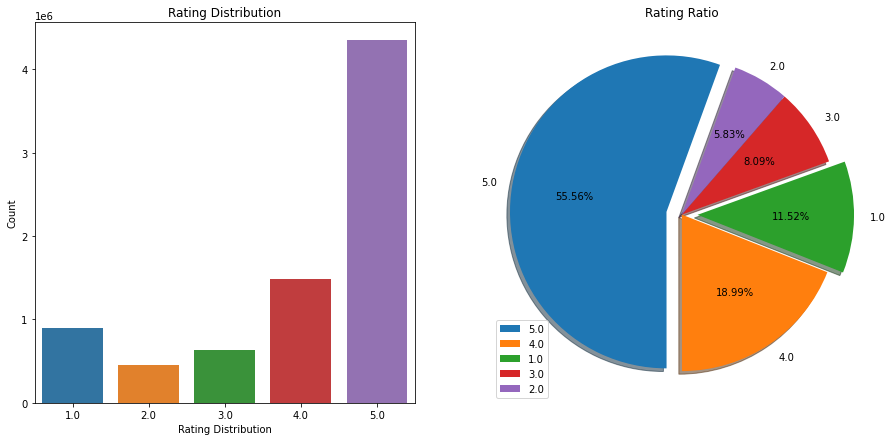

In [178]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(df1['Rating'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.set_title('Rating Distribution')


explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_counts["Ratings"], explode=explode, labels=rating_counts.Labels, autopct='%1.2f%%',
        shadow=True, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_counts.Labels, loc=3)
plt.show()

From a ratings per product perspective, the top 30 highest rated products received ratings of ~4,800 to 175,000

<AxesSubplot:>

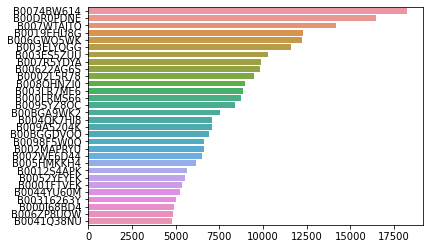

In [135]:
#Top 30 rated products 
prd = df1['productId'].value_counts()[:30]
sns.barplot(x= prd.values, y = prd.index)

The top 30 customers who provided ratings, rated between 250 and 520 products

<AxesSubplot:>

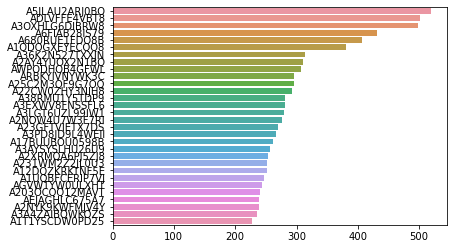

In [136]:
#Top 20 users based on number of ratings
usr = df1['userId'].value_counts()[:30]
sns.barplot(x= usr.values, y = usr.index)

### MODELING AND EVALUATION 1

To reduce the dimensionality of the dataset and improve processing time, rarely rated products and users who infrequently rated products are filtered out.  The final dataset will consist of users who provided 20 or more ratings and then a subsequent filter of products that received at least 50 ratings. 

In [14]:
#Subset of the data containing users who gave 20 or more ratings

df2=df1.groupby("userId").filter(lambda x:x['Rating'].count() >=20)

In [15]:
# Additional subset of the data containing products with 50 or more ratings

df3=df2.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [16]:
#Resulting dataset

print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df3.shape[0])
print("Total No of Users   :", len(np.unique(df3.userId)))
print("Total No of products  :", len(np.unique(df3.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 85410
Total No of Users   : 12933
Total No of products  : 880


In [111]:
#Revisiting 5 pt Summary and ratings distribution of condensed dataset

dfssc = pd.DataFrame([df3.Rating]).T
dfssc.describe()

,Rating
count,85410.000000
mean,4.407259
std,1.009711
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


We will use the Surpise package, additional reading and resources are available in the following links:

http://surpriselib.com/

https://github.com/NicolasHug/Surprise

**Reading the Data into Surprise**

In [19]:
#Reading the dataset into Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df3,reader)

In [20]:
#Splitting the dataset into train and test - - reserving 30% for testing
trainset, testset = train_test_split(data, test_size=0.3,random_state=28)

In [21]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of products: ', trainset.n_items, '\n')

Number of users:  12484 

Number of products:  880 



**GridSearchCV** 

Utilized to compare accuracy metrics for the selected algorithms on various combinations of parameters, with  a cross-validation of five to identify the best set of parameters for each algorithm.

n_factors: determines the size of pᵤ and qᵢ vectors - - how many latent factors the model will try to find. 

n_epochs: determines how many times the gradient descent calculations are repeated. 

lr_all: Learning rate factor for all of the parameters. Step sizes the model will use to minimise the cost function

reg_all: Regularisation factor for all of the parameters. Surprise uses an L2 regularisation


MSD (mean square difference) similarities will be computed between user - item similarity for all models.  Cosine was attempted but the processing became prohibitive.  When compared using the KNN algorithm, the difference in RMSE with MSD and Cosine was not significant enough to warrant the level of processing required.

In [23]:
# Grid Search Parameters

param_grid = {'n_factors': [5, 10, 20],
              'n_epochs': [20, 30, 50],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.05, 0.1]}

#### Neighborhood-based algorithm

**KNN with Means**

Basic collaborative filtering algorithm, taking into account the mean ratings of each user.


In [24]:
# Tune algorithm parameters with GridSearchCV and k=5 cross-validation 
gskn = GridSearchCV(KNNWithMeans, param_grid, measures = ['rmse', 'mae'], cv = 5)
gskn.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

In [25]:
# Best RMSE scores
gskn.best_score

{'rmse': 1.0504323772786677, 'mae': 0.6977829957974389}

In [26]:
# Combination of parameters that gave the best scores
gskn.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.02},
 'mae': {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.02}}

#### Matrix Factorization-based algorithms

**SVD**

Singular Value Decomposition (SVD) for dimension reduction of a large User-Item Sparse matrix. Through this reduction we can get a useful part of the data, that is hidden correlation (latent factors) and remove redundant parts. This tends to provide more robust recommendations while avoiding computational complexity.

In [30]:
# Tune algorithm parameters with GridSearchCV and k=5 cross-validation 
gssvd = GridSearchCV(SVD, param_grid, measures = ['rmse', 'mae'], cv = 5)
gssvd.fit(data)

In [31]:
# Best RMSE and MAE scores
gssvd.best_score

{'rmse': 0.9394581826721069, 'mae': 0.6581228758095697}

In [32]:
# Combination of parameters that gave the best scores
gssvd.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1},
 'mae': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.05}}

**SVD++**

Similar to SVD but also takes into account user and item bias.


In [34]:
# Tune algorithm parameters with GridSearchCV and k=5 cross-validation 
gssvdp = GridSearchCV(SVDpp, param_grid, measures = ['rmse', 'mae'], cv = 5)
gssvdp.fit(data)

In [35]:
# Best RMSE and MAE scores
gssvdp.best_score

{'rmse': 0.9396307342812678, 'mae': 0.6577531041830068}

In [36]:
# Combination of parameters that gave the best scores
gssvdp.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1},
 'mae': {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}}

### MODELING & EVALUATION 2 - Evaluate and Compare

**RMSE and MAE comparison between the three models**

The results of the three models will first be compared using RMSE, while acknowledging MAE, to evaluate the recommendation error rates and model performance.  

Mean absolute error is the average of the difference between the rating predicted by the recommender and the actual rating given by the customer. MAE is a linear score which means that all the individual differences are weighted equally in the average.


![](files/mae.png)

RMSE is a quadratic scoring rule which measures the average magnitude of the error and gives a relatively high weight to large errors. This means the RMSE is most useful when large errors are particularly undesirable as is the case in this analysis.  The goal is to recommend the best product to the customer based on how they evaluated other products so the model should be as accurate as possible.

![](files/rmse.png)

The SVD and SVD++ models performed similarly from an RMSE perspective and both performed better than KNNwithMeans.

![](files/Model.png)

Comparing the best parameters from an RMSE perspective for SVD and SVD++, there is no difference (see output below).  One of the benefits of the SVD++ algorithm is that it can handle both explicit (numerical ratings) and implicit (likes, purchases, bookmarks) interaction, but it is more computationally expensive vs. SVD.

Considering the simailar performance between the two matrix factorization algorithms and the fact that our data only includes numerical ratings, we will go with the simpler, less computationally expensive model and move forward with SVD as the best model to compare against KNNWithMeans from a Precision and Recall perspective.

In [167]:
gssvd.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1},
 'mae': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.05}}

In [166]:
gssvdp.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1},
 'mae': {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}}

**PRECISION AND RECALL**  <br>
https://surprise.readthedocs.io/en/stable/FAQ.html

Next, we will review precision, recall and the resulting F1 score on the test data to understand how well KNNWithMeans and SVD selected relevant items for the customer.  Both precision and recall are commonly used to understand recommender systems' performance. Precision tells us how many recommendations are relevant among the provided recommendations and Recall tells us how many recommendations are provided among all the relevant recommendations.  The F1 Score is a balance between these two metrics.

![](files/rp.png)

Precision and Recall were calculated on the test data with k set at a max of 10.  Because of the dominance of higher ratings when the models were trained, the threshhold was set at 4.  This means that any product with a projected rating of < 4 will not be recommended to the user. Many times in a 1 - 5 rating system the threshhold is set at 3.5 for the cutoff.

Both models were compared based on the F Score, which indicates the balance between the precision and the recall of the model.

The KNN model ranged from 0.6607 to 0.8511 (k = 10)
The SVD model range from 0.7024 to 0.8884 (k = 9)

However, from the resulting charts it appears that the "best" k appears to be around 5 or 6 as the gains level off after that point. 

The SVD model outperformed KNNWithMeans, and we finalize our decision to move forward with SVD as the best model for our recommender system.  

In [163]:
# Returns the precision and recall of the model at k metrics
def get_precision_vs_recall(algo, k_max = 10, verbose = False):
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    if algo:
        for k_curr in range(1, k_max + 1):
            algo.fit(trainset)
            predictions = algo.test(testset)
            
            # Get precision and recall at k metrics for each user
            precisions, recalls = precision_recall_at_k(predictions, k = k_curr, threshold = 4)
            
            # Precision and recall can then be averaged over all users
            precision = sum(prec for prec in precisions.values()) / len(precisions)
            recall = sum(rec for rec in recalls.values()) / len(recalls)
            f1_score = 2 * (precision * recall) / (precision + recall)
            
            # Save measures
            precision_list.append(precision)
            recall_list.append(recall)
            f1_score_list.append(f1_score)
            
            if verbose:
                print('K =', k_curr, '- Precision:', precision, ', Recall:', recall, ', F1 score:', f1_score)
    
    return {'precision': precision_list, 'recall': recall_list, 'f1_score': f1_score_list};

**KNN with Means**

In [164]:
# Use KNN algorithm with the best params

algo = KNNWithMeans(n_factors=5, n_epochs=20, lr_all=0.002, reg_all=0.02, verbose=False)

In [165]:
# Calculate the precision and recall of the model at k metrics

metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.9122755372387401 , Recall: 0.5178742422641204 , F1 score: 0.6606916413298106
K = 2 - Precision: 0.9078108134628594 , Recall: 0.6883906718726991 , F1 score: 0.7830195643272752
K = 3 - Precision: 0.9062735093055987 , Recall: 0.7537310430645283 , F1 score: 0.8229934990182526
K = 4 - Precision: 0.9052350112844683 , Recall: 0.7806247983443343 , F1 score: 0.8383246271156571
K = 5 - Precision: 0.9048081640663362 , Recall: 0.7921030736516965 , F1 score: 0.8447128074723541
K = 6 - Precision: 0.9044549111961557 , Recall: 0.7976513907697537 , F1 score: 0.8477023050451017
K = 7 - Precision: 0.9044408932251167 , Recall: 0.8007845552518759 , F1 score: 0.849462221056756
K = 8 - Precision: 0.9043497764133642 , Recall: 0.8024066687749046 , F1 score: 0.8503337351324685
K = 9 - Precision: 0.9042543763326828 , Recall: 0.8033216241283083 , F1 score: 0.8508049937743263
K = 10 - Precision: 0.9042064037206833 , Recall: 0.8039289097966504 , F1 score: 0.8511242202205572


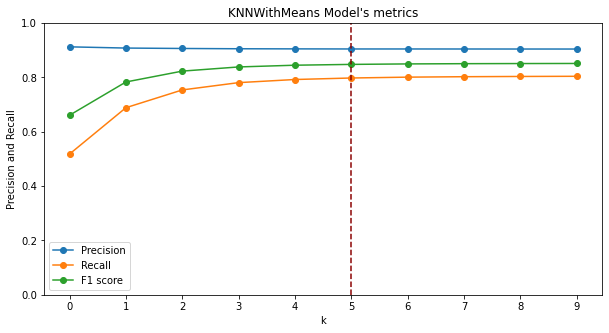

In [61]:
# Get data
c1 = metrics['precision']
c2 = metrics['recall']
c3 = metrics['f1_score']
x = np.arange(len(c1))

# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0, 1)
ax1.plot(x, c1, marker = 'o')
ax1.plot(x, c2, marker = 'o')
ax1.plot(x, c3, marker = 'o')
ax1.axvline(x = 5, color = "#8b0000", linestyle = "--")

# Chart setup
plt.title("KNNWithMeans Model's metrics", fontsize = 12)
plt.xlabel("k", fontsize = 10)
plt.ylabel("Precision and Recall", fontsize = 10)
plt.legend(("Precision", "Recall", "F1 score"), loc = "best")
plt.draw()

**SVD**

In [82]:
# Use SVD algorithm with the best params

algo = SVD(n_factors=5, n_epochs=30, lr_all=0.005, reg_all=0.01, verbose=False)

In [83]:
# Calculate the precision and recall of the model at k metrics

metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.9123736630360122 , Recall: 0.5711086494579026 , F1 score: 0.7024883089053937
K = 2 - Precision: 0.9042782847610636 , Recall: 0.7555479710656188 , F1 score: 0.8232495671538063
K = 3 - Precision: 0.8999443953815487 , Recall: 0.8265070954991033 , F1 score: 0.861663860544483
K = 4 - Precision: 0.898333496876331 , Recall: 0.8554583714263627 , F1 score: 0.8763718479083966
K = 5 - Precision: 0.8973424263238842 , Recall: 0.86799908123007 , F1 score: 0.8824268825776622
K = 6 - Precision: 0.8973064468648835 , Recall: 0.8744081028591119 , F1 score: 0.8857093012061148
K = 7 - Precision: 0.8966971323903938 , Recall: 0.8760654790928876 , F1 score: 0.8862612487427421
K = 8 - Precision: 0.8979474185906358 , Recall: 0.8785021541506365 , F1 score: 0.8881183610842268
K = 9 - Precision: 0.897436852934353 , Recall: 0.8795971935400622 , F1 score: 0.8884274769935845
K = 10 - Precision: 0.897568972311395 , Recall: 0.879260123244914 , F1 score: 0.8883202185162752


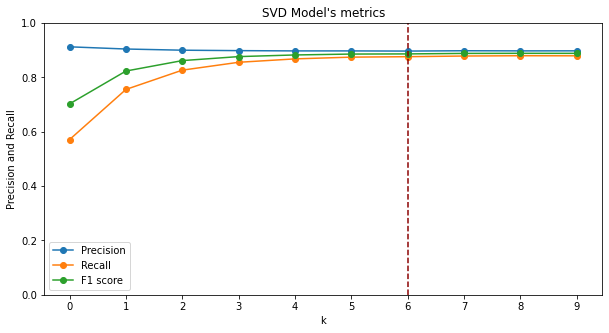

In [84]:
# Get data
c1 = metrics['precision']
c2 = metrics['recall']
c3 = metrics['f1_score']
x = np.arange(len(c1))

# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0, 1)
ax1.plot(x, c1, marker = 'o')
ax1.plot(x, c2, marker = 'o')
ax1.plot(x, c3, marker = 'o')
ax1.axvline(x = 6, color = "#8b0000", linestyle = "--")

# Chart setup
plt.title("SVD Model's metrics", fontsize = 12)
plt.xlabel("k", fontsize = 10)
plt.ylabel("Precision and Recall", fontsize = 10)
plt.legend(("Precision", "Recall", "F1 score"), loc = "best")
plt.draw()

### MODELING AND EVALUATION 3

**Best Model - SVD**

In [94]:
# Show best params for best algo
gssvd.best_params['rmse']

{'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}

RMSE comes in at 0.942 when we run the test data through the SVD model.  When we evaluated the model parameters, RMSE was 0.939. 

In [174]:
# SVD algorithm with the best params
algo = SVD(n_factors=5, n_epochs=30, lr_all=0.005, reg_all=0.01, random_state = 26, verbose=False)
algo.fit = algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=False)

0.9415220525522613

We are going to take a quick look at the predictions to see how well the model performed vs. the original rating provided. 

In [185]:
#https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb
# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_pred['Iu'] = df.uid.apply(get_Iu)
df_pred['Ui'] = df.iid.apply(get_Ui)
df_pred['err'] = abs(df.est - df.rui)

In [200]:
df_pred.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,A2VRAT69JDAD3W,B003Y74AXO,3.0,3.964217,{'was_impossible': False},7,36,0.964217
1,A29L0NIWBAGELM,B003WUBIZQ,5.0,3.642905,{'was_impossible': False},6,67,1.357095
2,AKDIEY3APNBR,B004CLYEDC,5.0,4.678028,{'was_impossible': False},7,117,0.321972
3,ADZKP93810RSP,B00008SCFL,1.0,3.345459,{'was_impossible': False},2,40,2.345459
4,A2NKI99LU8CBMZ,B000CKVOOY,5.0,4.797831,{'was_impossible': False},3,111,0.202169


There appears to be minimal absolute errors when ratings are greater than or equal to 3.  When products were rated lower, the model tends to predict higher ratings as shown in the charts below.   

<IPython.core.display.Javascript object>


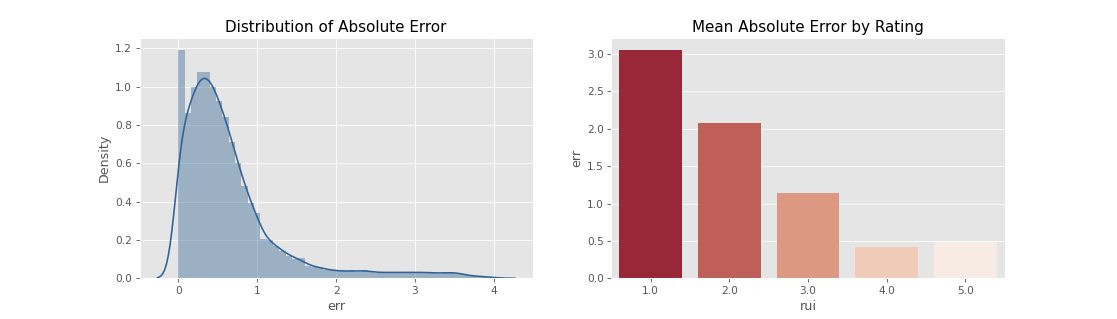

In [201]:
df_pred_err = df_pred.groupby('rui')['err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of Absolute Error')

sns.barplot(x='rui', y='err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean Absolute Error by Rating')

plt.show()

We need to better understand what is happening when there are lower ratings.  Is there an issue with the model or are there other causes?

In [202]:
best_predictions = df_pred.sort_values(by='err')[:10]
worst_predictions = df_pred.sort_values(by='err')[-20:]

In [203]:
# Let's take a look at the best predictions of the algorithm - Nothing to see here, rating 5 = predicted 5
#best_predictions

The table below shows the 20 worst rating predictions, which happen to be ratings of 1 and the model predicted ratings around 5.  "Ui" indicates how many ratings the product received, so we will take a look at the rating distribution for a few products to see if we can gain any insights.  

In [204]:
# Now, let's look at the prediction with the biggest error
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
12803,A23HKKR7O9IK4F,B007WTAJTO,1.0,4.888714,{'was_impossible': False},2,625,3.888714
20565,A1BZIM4WGZ6DZP,B0035ERKYW,1.0,4.892542,{'was_impossible': False},5,53,3.892542
9692,AK2RNPCHB83EW,B004G6002M,1.0,4.895876,{'was_impossible': False},3,198,3.895876
20045,A2FA749WEY82I3,B001QUA6RA,1.0,4.906176,{'was_impossible': False},3,93,3.906176
2008,A3F2K1RC9IMNLX,B004GF8TIK,1.0,4.933081,{'was_impossible': False},7,152,3.933081
12456,A6ME5B3NRT981,B00BWF5U0M,1.0,4.956409,{'was_impossible': False},7,72,3.956409
1087,A11EYMH9UV9XG7,B00D1GYNT4,1.0,4.965798,{'was_impossible': False},6,37,3.965798
5522,A38NHXL5257E3B,B005QX7KYU,1.0,4.986853,{'was_impossible': False},20,76,3.986853
19510,A2V5M5EJPOD2IU,B0038P1TP4,1.0,4.987357,{'was_impossible': False},21,33,3.987357
3466,A3F2K1RC9IMNLX,B007WTAJTO,1.0,5.000000,{'was_impossible': False},7,625,4.000000


The ratings distribution for the selected products show that the lower ratings are outliers for the products. The majority of customers rated the products highly which drove the higher predicted rating for the product.  Our model may be doing what we expect.

<IPython.core.display.Javascript object>


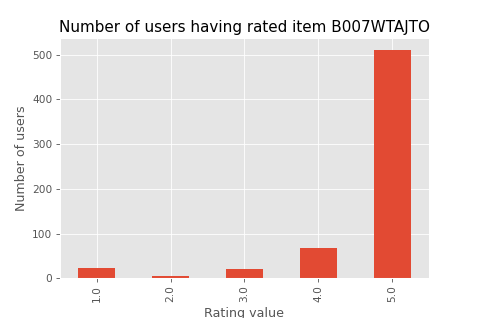

Text(0.5, 1.0, 'Number of users having rated item B007WTAJTO')

In [194]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')

counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('B007WTAJTO')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item B007WTAJTO')

<IPython.core.display.Javascript object>


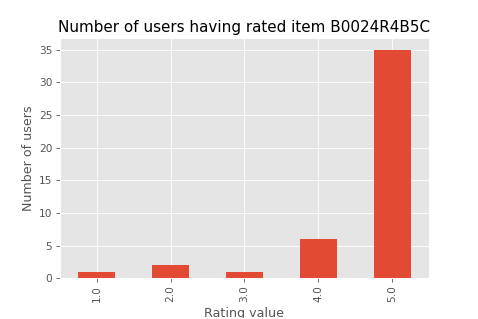

Text(0.5, 1.0, 'Number of users having rated item B0024R4B5C')

In [213]:
counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('B0024R4B5C')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item B0024R4B5C')

<IPython.core.display.Javascript object>


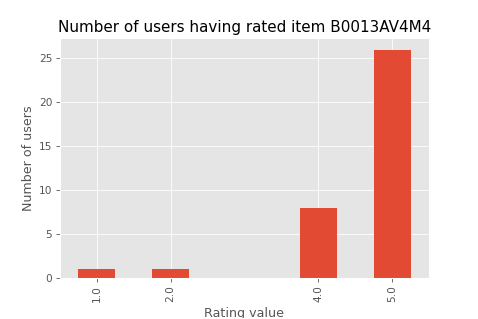

Text(0.5, 1.0, 'Number of users having rated item B0013AV4M4')

In [212]:
counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('B0013AV4M4')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item B0013AV4M4')

For a more holistic view of the model's behavior, we are exporting the predictions to excel to run some pivots / charts to investigate the model's behavior for varying ratings distributions of a product to see if our outlier theory is reasonable or if there is bias in the model towards higher ratings.

In [197]:
df_pred.to_csv('svdpred.csv')

The charts below show the actual ratings of the product in the left chart and the comparison between actual ratings and the model's predicted ratings in the right chart.

In the first two charts, product ratings have concentrations in either the lower and highest or low - mid - high.  In these scenarios, the model appears to place a heavier emmphasis on the higher ratings and predict a rating between 3 and 4, especially in the first scenario.

![](files/c1.png)

![](files/c2.png)

In the third chart, the highest concentration is a rating of 4 and the model seems to do a better job accounting for the other ratings, but there is still a disconnect on the lower end.

![](files/c3.png)

In the final chart where the product predominately received 4's and 5's, the predicted ratings seemed to capture the nuances of the actual ratings better, It appears the model is condsidering the two customers who rated the product a 2 as outliers.

![](files/c4.png)

**Recommendations**<br>
We know that the best number of predictions from our review of precision, recall and F1 is approximately 6 for the SVD model.  We pull the top 6 predictions for each user to make sure our system is working as designed.

In [218]:
def get_top_n(predictions, n=6):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [219]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=6)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A3JJUCA6K4P31H ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B0035FZJHQ', 'B009O7YUF6', 'B000V5P90K']
A3B6TOMVGHAJTP ['B006JINHYS', 'B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B007SZ0E1K', 'B005GGTTZ0']
A13XP8Y6A33IVB ['B0029N3U8K', 'B001MSU1HG', 'B005ES0YYA', 'B001TH7GUA', 'B006JINHYS', 'B009O7YUF6']
A2N9YI94O8TR8M ['B005GGTTZ0', 'B0029N3U8K', 'B0052SCU8U', 'B003ES5ZUU', 'B004ELA0SS', 'B001MSU1HG']
A349KBMEGAI5TH ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0033PRWSW', 'B007SZ0E1K', 'B002NO7PWC']
A34KBI5VOYXG9U ['B008LTBITY', 'B006JINHYS', 'B001TH7GUA', 'B0076W9Q5A', 'B0033PRWSW', 'B0035FZJHQ']
A2WS0U0603Z04P ['B008LTBITY', 'B0076W9Q5A', 'B001TH7GUA', 'B006JINHYS', 'B0033PRWSW', 'B0019EHU8G']
A19E3ZCQH6TJBD ['B0019EHU8G', 'B005ES0YYA', 'B001TH7GUA', 'B006JINHYS', 'B0033PRWSW', 'B008LTBITY']
AY417SGF5G5QZ ['B008LTBITY', 'B006JINHYS', 'B0076W9Q5A', 'B0033PRWSW', 'B007SZ0E1K', 'B002NO7PWC']
A37M3UTGX8CYIO ['B0019EHU8G', 'B00005LEN4', 'B0029N3U8K', 'B003ES5ZUU', 'B001MSU1HG', 'B005ES0YYA']
A

ADHA1W879JNT0 ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B0076W9Q5A', 'B005GGTTZ0', 'B002NO7PWC']
A21TCQNAG821DR ['B005GGTTZ0', 'B0019EHU8G', 'B00005LEN4', 'B0029N3U8K', 'B004S4R5CK', 'B001MSU1HG']
A30X750M8V1XXW ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B0076W9Q5A', 'B001E1Y5O6', 'B005VFG06W']
A1N48V6JN37P2G ['B001TH7GUA', 'B006JINHYS', 'B0033PRWSW', 'B008LTBITY', 'B0076W9Q5A', 'B0035FZJHQ']
A1E8XXAKINL0B1 ['B008LTBITY', 'B0033PRWSW', 'B001MSU1HG', 'B0076W9Q5A', 'B0000BZL1P', 'B009O7YUF6']
A3SP7T2PZ3HSDE ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B0035FZJHQ', 'B000V5P90K', 'B001MSU1HG']
A3PAYT2SQY7J3H ['B006JINHYS', 'B0033PRWSW', 'B008LTBITY', 'B0076W9Q5A', 'B0000BZL1P', 'B005GGTTZ0']
A3MJ3YYO1AMNRO ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B0000BZL1P', 'B0029N3U8K', 'B0035FZJHQ']
A2YIO225BTKVPU ['B008LTBITY', 'B0076W9Q5A', 'B0035FZJHQ', 'B0033PRWSW', 'B000V5P90K', 'B001TH7GUA']
A2QKCOX5ACRHC5 ['B0076W9Q5A', 'B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B007SZ0E1K', 'B0035FZJHQ']
A

A2PSEAZRZ7WMF9 ['B0019EHU8G', 'B0029N3U8K', 'B001MSU1HG', 'B005ES0YYA', 'B001TH7GUA', 'B006JINHYS']
A1GGH56COJNMS8 ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0076W9Q5A', 'B0019EHU8G', 'B0000BZL1P']
A2O8LMXTUV715H ['B005GGTTZ0', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4', 'B00E3W15P0']
A2UOHALGF2X77Q ['B005GGTTZ0', 'B001MSU1FS', 'B00005LEN4', 'B005LFT3GG', 'B0029N3U8K', 'B003ES5ZUU']
A3VBORHS4H8LES ['B005GGTTZ0', 'B001MSU1FS', 'B00005LEN4', 'B001TH7GSW', 'B0029N3U8K', 'B000OGX5AM']
A1WS0MZBFZ7VX3 ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B006JINHYS', 'B0000BZL1P', 'B002NO7PWC']
A17A1KTVI3DG6U ['B0076W9Q5A', 'B007SZ0E1K', 'B005GGTTZ0', 'B009OBCAW2', 'B004LSNF04', 'B008LTBITY']
AKT8TGIT6VVZ5 ['B003O1UYHG', 'B005GGTTZ0', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4']
A4OXSQLCWYDFK ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0000BZL1P', 'B0076W9Q5A', 'B0029N3U8K']
A1IG1I6MR3HAWA ['B0090Z3QG6', 'B003O1UYHG', 'B005GGTTZ0', 'B00609B3J2', 'B001MSU1FS', 'B0019EHU8G']
A2

AOJF59EUDPR7A ['B005GGTTZ0', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4', 'B005LFT3GG']
A2WCFDOCS73PNB ['B0019EHU8G', 'B0029N3U8K', 'B005ES0YYA', 'B006JINHYS', 'B0033PRWSW', 'B000F7QRTG']
A28525P0S5ZVJ3 ['B0076W9Q5A', 'B006JINHYS', 'B008LTBITY', 'B001CCAISE', 'B009OBCAW2', 'B007SZ0E1K']
A1BEBL1H1LH10G ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B006JINHYS', 'B0000BZL1P', 'B0035FZJHQ']
A2VXDHUVIYB8QF ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B006JINHYS', 'B0035FZJHQ', 'B001TH7GUA']
APBTROUF4UK5T ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B006JINHYS', 'B0035FZJHQ', 'B000V5P90K']
A3ORK411MGLXNS ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0033PRWSW', 'B0019EHU8G', 'B005JN9310']
A3872Y2XH0YDX1 ['B005GGTTZ0', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4', 'B005LFT3GG']
A3HVGH7PARA3BG ['B0090Z3QG6', 'B003O1UYHG', 'B005GGTTZ0', 'B00609B3J2', 'B001MSU1FS', 'B0019EHU8G']
A35JWG51KXPRJZ ['B001MSU1HG', 'B009O7YUF6', 'B000V5P90K', 'B0033PRWSW', 'B008LTBITY', 'B007SZ0E1K']
A3

A3KMYHC1E69P32 ['B008LTBITY', 'B0076W9Q5A', 'B0019EHU8G', 'B006JINHYS', 'B0035FZJHQ', 'B0033PRWSW']
A1WOCDLPG4LGWZ ['B008LTBITY', 'B001MSU1HG', 'B00BQ4F9ZA', 'B0076W9Q5A', 'B0033PRWSW', 'B000JV9LUK']
A1QD80T2XYR9ZZ ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B0076W9Q5A', 'B001TH7GUA', 'B005ES0YYA']
A2BVV8ND8Q6S6A ['B005GGTTZ0', 'B0019EHU8G', 'B00005LEN4', 'B005LFT3GG', 'B00E3W15P0', 'B0029N3U8K']
A1HYH206E18XVC ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B001TH7GUA', 'B0019EHU8G', 'B0076W9Q5A']
A2JU02EQY3RFEU ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0033PRWSW', 'B001TH7GUA', 'B007SZ0E1K']
AA7L81AIMR3AP ['B005GGTTZ0', 'B00609B3J2', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4']
A132CBT7KF85K9 ['B008LTBITY', 'B006JINHYS', 'B0076W9Q5A', 'B0033PRWSW', 'B001TH7GUA', 'B007SZ0E1K']
A2WU7IKAQINJAY ['B005GGTTZ0', 'B0019EHU8G', 'B00005LEN4', 'B0029N3U8K', 'B0052SCU8U', 'B004ELA0SS']
A1JVOV54H4ZVFC ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B006JINHYS', 'B005GGTTZ0', 'B007SZ0E1K']
A

A1YQK9S2QR3X4H ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0076W9Q5A', 'B005GGTTZ0', 'B002NO7PWC']
A567HBSX35U7X ['B006JINHYS', 'B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B007SZ0E1K', 'B001CCAISE']
A1MFO2DXH2C2B5 ['B0033PRWSW', 'B008LTBITY', 'B0000BZL1P', 'B0029N3U8K', 'B0035FZJHQ', 'B0076W9Q5A']
AEM57NVIFQ8B9 ['B005GGTTZ0', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4', 'B005LFT3GG']
A2K4WOSH37GSW6 ['B008LTBITY', 'B0033PRWSW', 'B0000BZL1P', 'B006JINHYS', 'B0029N3U8K', 'B000M2TAN4']
A3EYZZFIRHA06G ['B0019EHU8G', 'B00005LEN4', 'B0029N3U8K', 'B001MSU1HG', 'B005ES0YYA', 'B001TH7GUA']
AP9YDYTA4QM6W ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0033PRWSW', 'B0019EHU8G', 'B000F7QRTG']
A1PEXTGNF36I1Q ['B005GGTTZ0', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4', 'B00E3W15P0']
A8YFJMSXIFDXW ['B006JINHYS', 'B0033PRWSW', 'B008LTBITY', 'B0076W9Q5A', 'B007SZ0E1K', 'B001MSU1HG']
A10C5CJK1YKGV0 ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B006JINHYS', 'B007SZ0E1K', 'B001MSU1HG']
A3MW

A3MY87GH376958 ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B001MSU1HG', 'B007SZ0E1K', 'B0035FZJHQ']
A3TSD77T9DBARX ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0076W9Q5A', 'B001TH7GUA', 'B0000BZL1P']
A3G3QUF116C6RU ['B008LTBITY', 'B0019EHU8G', 'B0000BZL1P', 'B0029N3U8K', 'B0033PRWSW', 'B000F7QRTG']
A2K6H0GJA067E4 ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0033PRWSW', 'B003XM1WE0', 'B001TH7GUA']
A3H7NPNDMGLOU4 ['B005GGTTZ0', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4', 'B001TH7GSW']
A1VR9II0HC7ZQ6 ['B0076W9Q5A', 'B008LTBITY', 'B007SZ0E1K', 'B0033PRWSW', 'B001MSU1HG', 'B000V5P90K']
A155GENGJ7837S ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B007SZ0E1K', 'B0000BZL1P', 'B0029N3U8K']
A2BLR3DOSX0QTA ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B0000BZL1P', 'B006JINHYS', 'B0029N3U8K']
A26NE82APGCHIB ['B006JINHYS', 'B0033PRWSW', 'B008LTBITY', 'B007SZ0E1K', 'B0076W9Q5A', 'B0000BZL1P']
A3DOPYDOS49I3T ['B008LCYIEI', 'B0090Z3QG6', 'B003O1UYHG', 'B005GGTTZ0', 'B00609B3J2', 'B003VAGXWK']


ARI60NK07Q9D ['B008LTBITY', 'B0076W9Q5A', 'B0019EHU8G', 'B0035FZJHQ', 'B0033PRWSW', 'B0029N3U8K']
A1UCSWDY9MRISV ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B0076W9Q5A', 'B005GGTTZ0', 'B007SZ0E1K']
AHZUV9VVAOO1Z ['B005GGTTZ0', 'B0029N3U8K', 'B0052SCU8U', 'B004S4R5CK', 'B001MSU1HG', 'B005ES0YYA']
A2LXX47A0KMJVX ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B006JINHYS', 'B007SZ0E1K', 'B002NO7PWC']
A3LQQQTERW2XRP ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B0076W9Q5A', 'B001TH7GUA', 'B001E1Y5O6']
A27ZQYVUU3Q7EY ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0033PRWSW', 'B0019EHU8G', 'B001CCAISE']
A3UW23DBF2KHWC ['B005GGTTZ0', 'B0019EHU8G', 'B00005LEN4', 'B0029N3U8K', 'B003ES5ZR8', 'B0052SCU8U']
AOFHTWA03NGAS ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0019EHU8G', 'B005UA3I72', 'B0000BZL1P']
AK4HKI46S49NA ['B008LTBITY', 'B0019EHU8G', 'B0076W9Q5A', 'B006JINHYS', 'B001TH7GUA', 'B0033PRWSW']
A1JBUBTQ48ITN4 ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B006JINHYS', 'B0000BZL1P', 'B0029N3U8K']
A2IET

A2SR7S6ZJJDGNB ['B005GGTTZ0', 'B0019EHU8G', 'B00005LEN4', 'B005LFT3GG', 'B0029N3U8K', 'B0052SCU8U']
A1KHE7CY3WMD4K ['B007WTAJTO', 'B006JINHYS', 'B0033PRWSW', 'B000F7QRTG', 'B003XM1WE0', 'B008LTBITY']
AX4EJPMBBNP90 ['B0019EHU8G', 'B0029N3U8K', 'B001MSU1HG', 'B005ES0YYA', 'B001TH7GUA', 'B006JINHYS']
A31RZMVAFMLB8B ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B0076W9Q5A', 'B001TH7GUA', 'B0035FZJHQ']
A2KWOC600DMC0W ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B006JINHYS', 'B007SZ0E1K', 'B002NO7PWC']
ARNSIMLKU7PT6 ['B001MSU1HG', 'B001TH7GUA', 'B006JINHYS', 'B009NB8WR0', 'B009O7YUF6', 'B000V5P90K']
ACEA95FQS1AVP ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0033PRWSW', 'B001TH7GUA', 'B0035FZJHQ']
A3N3CNQD0L3HX9 ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B001TH7GUA', 'B0033PRWSW', 'B0035FZJHQ']
A10RN92S0XE4G5 ['B005GGTTZ0', 'B0019EHU8G', 'B004S4R5CK', 'B00104XCVO', 'B005ES0YYA', 'B001TH7GUA']
A3UHFJ087RWHC3 ['B008LTBITY', 'B0019EHU8G', 'B001TH7GUA', 'B005UA3I72', 'B0033PRWSW', 'B006JINHYS']
AO2

A21Y5X34AATMER ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B006JINHYS', 'B007SZ0E1K', 'B0000BZL1P']
A2XOS0D485JSMM ['B006JINHYS', 'B0033PRWSW', 'B008LTBITY', 'B0076W9Q5A', 'B0019EHU8G', 'B001TH7GUA']
A3CZ8FSR0VWSR5 ['B005GGTTZ0', 'B001MSU1FS', 'B0029N3U8K', 'B0052SCU8U', 'B004ELA0SS', 'B004S4R5CK']
A3SGQUKYUATAM8 ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B007SZ0E1K', 'B001MSU1HG', 'B006JINHYS']
AD0J5KK4WQXNS ['B0029N3U8K', 'B003ES5ZUU', 'B001MSU1HG', 'B005ES0YYA', 'B001TH7GUA', 'B006JINHYS']
A1VOFY3QFT9WCG ['B001MSU1HG', 'B00BQ4F9ZA', 'B001TH7GUA', 'B009O7YUF6', 'B0033PRWSW', 'B008LTBITY']
A3K8RKQ83N278G ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B0029N3U8K', 'B0019EHU8G', 'B0000BZL1P']
A9SNYKHZ13HPJ ['B0076W9Q5A', 'B008LTBITY', 'B0033PRWSW', 'B007SZ0E1K', 'B006JINHYS', 'B000V5P90K']
A1NQKWS81ENDTV ['B005GGTTZ0', 'B0019EHU8G', 'B00005LEN4', 'B005LFT3GG', 'B00E3W15P0', 'B0029N3U8K']
A2RI4QE6EO29CA ['B0019EHU8G', 'B0029N3U8K', 'B001MSU1HG', 'B006JINHYS', 'B0033PRWSW', 'B0000510ZO']
AO

A2GOLLBPLVKF3H ['B005GGTTZ0', 'B0052SCU8U', 'B004S4R5CK', 'B001MSU1HG', 'B00104XCVO', 'B005ES0YYA']
A17AK1Z8KN613L ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B0076W9Q5A', 'B001TH7GUA', 'B002NO7PWC']
A2OBG64SMNSGFW ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0076W9Q5A', 'B001TH7GUA', 'B0035FZJHQ']
AB2QLDYMBY6YQ ['B001MSU1HG', 'B006JINHYS', 'B000V5P90K', 'B0033PRWSW', 'B008LTBITY', 'B002NO7PWC']
A1LTCG19G04SWV ['B005GGTTZ0', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4', 'B005LFT3GG']
AFMXCXU7KZ302 ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0000BZL1P', 'B0029N3U8K', 'B0076W9Q5A']
A3500UVGFOC9PA ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0033PRWSW', 'B001CCAISE', 'B007SZ0E1K']
A3DDPLYMNIVED0 ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0019EHU8G', 'B001CCAISE', 'B0000510ZO']
A3OC42X7H74D1Y ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B0000BZL1P', 'B006JINHYS', 'B0019EHU8G']
A34HYH25VI5DX3 ['B005GGTTZ0', 'B00609B3J2', 'B001MSU1FS', 'B0019EHU8G', 'B00APCMMDG', 'B00005LEN4']
A1

A2Q2VUSLNM0MUP ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B0000BZL1P', 'B0029N3U8K', 'B0035FZJHQ']
A127GZ51PD786F ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0076W9Q5A', 'B0000BZL1P', 'B002NO7PWC']
A12VM49BC8EP1X ['B005GGTTZ0', 'B0019EHU8G', 'B0029N3U8K', 'B000OGX5AM', 'B003ES5ZUU', 'B004ELA0SS']
A20BB7TPL5F7G2 ['B008LTBITY', 'B0076W9Q5A', 'B006JINHYS', 'B0033PRWSW', 'B007SZ0E1K', 'B005GGTTZ0']
AXFINZCCNA8NV ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B0035FZJHQ', 'B001TH7GUA', 'B000V5P90K']
AOMVLDY12N1CQ ['B0019EHU8G', 'B008LTBITY', 'B001TH7GUA', 'B005UA3I72', 'B0033PRWSW', 'B0000BZL1P']
A2UQW75PB93971 ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B006JINHYS', 'B001MSU1HG', 'B0000BZL1P']
A2NOSUGEJQ3GI3 ['B008LTBITY', 'B0076W9Q5A', 'B007SZ0E1K', 'B009OBCAW2', 'B0035FZJHQ', 'B002NO7PWC']
ABJNCFD48KB8 ['B005GGTTZ0', 'B0019EHU8G', 'B001TH7GUA', 'B006JINHYS', 'B000F9YN22', 'B001CCAISE']
A2J559AG3AFAZY ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0076W9Q5A', 'B0000BZL1P', 'B001MSU1HG']
AU62

A1QKCFVF2TJ8H1 ['B008LTBITY', 'B0019EHU8G', 'B0033PRWSW', 'B001TH7GUA', 'B0000BZL1P', 'B005UA3I72']
A1PNF6GT0Z0TR0 ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B006JINHYS', 'B001MSU1HG', 'B001TH7GVE']
AJ88Z1U0SS1IY ['B0019EHU8G', 'B006JINHYS', 'B0033PRWSW', 'B008LTBITY', 'B0000BZL1P', 'B0076W9Q5A']
A1IM4D3R61A2K0 ['B008LTBITY', 'B0019EHU8G', 'B006JINHYS', 'B0033PRWSW', 'B005ES0YYA', 'B001TH7GUA']
A1H98YV5K5BUX0 ['B005GGTTZ0', 'B0029N3U8K', 'B0052SCU8U', 'B004S4R5CK', 'B001MSU1HG', 'B006JINHYS']
A7TNP04SNS41Y ['B008LTBITY', 'B0019EHU8G', 'B0033PRWSW', 'B006JINHYS', 'B001TH7GUA', 'B005UA3I72']
A15EQ9J0E2B95M ['B0076W9Q5A', 'B007SZ0E1K', 'B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B0035FZJHQ']
A36COCV5K2KYZ2 ['B001TH7GUA', 'B008LTBITY', 'B0076W9Q5A', 'B0035FZJHQ', 'B009O7YUF6', 'B000V5P90K']
A3G4O73F945W0R ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B006JINHYS', 'B005GGTTZ0', 'B007SZ0E1K']
A1CWOD9IBU4DNU ['B001TH7GUA', 'B009O7YUF6', 'B000V5P90K', 'B008LTBITY', 'B0076W9Q5A', 'B0035FZJHQ']
A2

A3ACKWYDNR7ROA ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B0076W9Q5A', 'B005JN9310', 'B002NO7PWC']
A33971CVQ44SXD ['B008LTBITY', 'B0019EHU8G', 'B0076W9Q5A', 'B001TH7GUA', 'B006JINHYS', 'B0033PRWSW']
AQBAN131RIXIZ ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0019EHU8G', 'B0000BZL1P', 'B005UA3I72']
A2VSI9JA8Q1OPM ['B008LTBITY', 'B0019EHU8G', 'B006JINHYS', 'B0076W9Q5A', 'B001CCAISE', 'B0033PRWSW']
A269OEVY5AJ95G ['B008LTBITY', 'B0033PRWSW', 'B0000BZL1P', 'B009O7YUF6', 'B0035FZJHQ', 'B001MSU1HG']
A2R6F8XP2DL6RC ['B008LTBITY', 'B0076W9Q5A', 'B0033PRWSW', 'B006JINHYS', 'B0019EHU8G', 'B002NO7PWC']
A1GO3HYUBF4AHD ['B005GGTTZ0', 'B0029N3U8K', 'B001MSU1HG', 'B001TH7GUA', 'B006JINHYS', 'B009O7YUF6']
A3MYOBKPI18WB3 ['B0019EHU8G', 'B0029N3U8K', 'B005ES0YYA', 'B001TH7GUA', 'B006JINHYS', 'B001CCAISE']
A2OM5R38PL5W2Y ['B008LTBITY', 'B0033PRWSW', 'B006JINHYS', 'B0076W9Q5A', 'B0000BZL1P', 'B001TH7GUA']
A2D9DSJIH4FRMC ['B008LTBITY', 'B006JINHYS', 'B0033PRWSW', 'B001TH7GUA', 'B0076W9Q5A', 'B005ES0YYA']
A

A16RLVQKEEFWUU ['B008LTBITY', 'B0033PRWSW', 'B009O7YUF6', 'B000V5P90K', 'B0076W9Q5A', 'B0035FZJHQ']
A1PFJC6JDGI8DW ['B0076W9Q5A', 'B008LTBITY', 'B0035FZJHQ', 'B007SZ0E1K', 'B000V5P90K', 'B0033PRWSW']
ARUDTZ5BNUHA6 ['B008LTBITY', 'B0033PRWSW', 'B0076W9Q5A', 'B006JINHYS', 'B0000BZL1P', 'B002NO7PWC']
A3CMO216CWOF5N ['B0019EHU8G', 'B0029N3U8K', 'B005ES0YYA', 'B001TH7GUA', 'B006JINHYS', 'B0033PRWSW']
A1HGS0BUALAMAU ['B006JINHYS', 'B0033PRWSW', 'B008LTBITY', 'B0076W9Q5A', 'B001CCAISE', 'B005GGTTZ0']
A2IHWM98N2ED4E ['B008LTBITY', 'B0019EHU8G', 'B006JINHYS', 'B0033PRWSW', 'B0000510ZO', 'B001CCAISE']
A1IU4JZFDZA9HJ ['B005GGTTZ0', 'B006JINHYS', 'B0033PRWSW', 'B008LTBITY', 'B007SZ0E1K', 'B0076W9Q5A']
A1MMA2K80OM7T3 ['B008LTBITY', 'B0076W9Q5A', 'B005GGTTZ0', 'B0033PRWSW', 'B006JINHYS', 'B007SZ0E1K']
A16TFHQFKN2XU2 ['B008LTBITY', 'B0019EHU8G', 'B001TH7GUA', 'B0033PRWSW', 'B0000BZL1P', 'B0076W9Q5A']
A1LA2EBAYLWYBH ['B0033PRWSW', 'B008LTBITY', 'B006JINHYS', 'B0000BZL1P', 'B0076W9Q5A', 'B0029N3U8K']
A

### MODELING AND EVALUATION 4 

We set out to develop a user-item collaborative filtering model to build a custom recommendation system for Amazon electronic products.

There are two types of collaborative filtering system: memory-based and model-based.  

A memory-based system uses users’ rating data to compute the similarity between users or items and produces a prediction for the user by taking the weighted average of all the ratings.  KNNWithMeans was selected from this category. 

In a model-based system, different machine learning algorithms are used to predict users’ rating of unrated items, reducing dimensionality through matrix factorization.  SVD and SVD++ were explored from this category.

GridSearch with cv=5 was employed to determine the best parameters for each model based on RMSE score.  As noted earlier, the SVD and SVD++ models had identical parameters.  The SVD model was selected to compare against KNNWithMeans based on precision, recall and resulting F1 score when the test data was run through the models. The performance of the SVD model surpassed KNNWithMeans and was selected as the final model.  For the SVD model, RMSE came in at 0.942 and F1 scores ranged from 0.7024 to 0.8884 (k = 9).

These are good results.  However, we need to understand where the model has weaker performance.  

From the onset, we were aware that of the product ratings ~75% were favorable, being either a 4 or 5.  Since opinions are opinions, this isn't something where we can artificially balance the data to achieve normally distributed ratings.  Nor would this be viable as it would not be representative of real-world activity. 

The model did very well predicting ratings when the actual product ratings were higher, but tended to overinflate when a user rated an item 1 or 2.  The mean absolute error where products had been rated a 4 or 5 was no more than 0.5.  For those rated 3 it was ~1.2.  For products rated 1 or 2 it was 3.1 and 2.1 respectively.

When we further reviewed the original ratings distribution for a few of the products, we saw that these lower ratings tended to be outliers as the majority of customers rated the product very well. Under this scenario, the model performed well, paying minimal attention to those ratings when predicting ratings. 

However, this can create an issue when recommending products as the model may not do a good job predicting for users who tend to be harsher raters, deviating from the larger group.  These are often referred to as "Gray Sheep" and this category does not benefit from collaborative filtering.

Alternatively, when the original rating distribution was not skewed towards the positive ratings, the model tended to predict "middle of the road" ratings seemingly placing more emphasis on positive ratings, resulting in larger absolute errors on the lower ratings.

As the model is deployed and more ratings are collected, this will be an area requiring attention to see if the model can be adjusted for improved performance.

There are also well-known issues with SVD Collaborative Filtering.  The primary one being data sparsity, referred to as the "cold start" problem. Because collaborative filtering is reliant on past ratings for it's recommendations, when there is a new customer the customer will need to rate a sufficient number of products in order for the model to capture their preferences accurately and provide reliable recommendations.  This is similar to when new products are introduced; sufficient ratings are also needed.



### DEPLOYMENT

We were able to achieve our goals as we could recommend products and we were able to visualize how effective our recommendations were by our evaluation metrics. Our RMSE and MAE were low which tells us our optimized parameters for the models worked well. We were also able to find the threshold number of recommendations per buyer that would suggest the most relevant recommendations. For KNN it was 5 while for SVD it was 6. 

As mentioned previously, our data was heavily skewed towards higher ratings. Because of this we would like to increase the amount of ratings data we have to better optimize the model taking all relevent ratings into consideration.  To do this, in the beginning we envision a bi-weekly update, provided there are sufficient new ratings for the products.  If the volume of ratings are not sufficient, we could see a monthly update.  Once we are satisified that we have the best model a quarterly update would be sufficient to capture changes in buyer preferences.

For addtional information the following information would be beneficial:  Item name, sub category of electronic product and price category so that we can better tailor the recommended products to the consumer.  For the next level, we would like to get post recommendation consumer actions.  For example, did they click through on any of the recommended products, was it added to their shopping cart and did they ultimately purchase the product?  This will give us valuable insights into how accurately we are predicting additional products to the customer and whether additioanl enhancements to the model are needed.

Any reatil company with an ecommerce presence will benefit from this system.  The model suggests relevant products to buyers which in turn increases customer engagment with our site to increase sales.  Provided this occurs, companies will realize revenue gains and enhanced customer loyalty.

### EXCEPTIONAL WORK

GridSearch utilized as best practice to identify best parameters.  
Group of two as we were abruptly abandoned after Lab 1 when a team member dropped the class

<i>Sources</i>

https://heartbeat.fritz.ai/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b

http://nicolas-hug.com/blog/matrix_facto_2

https://en.wikipedia.org/wiki/Collaborative_filtering

https://towardsdatascience.com/an-exhaustive-list-of-methods-to-evaluate-recommender-systems-a70c05e121de

https://medium.com/qloo/popular-evaluation-metrics-in-recommender-systems-explained-324ff2fb427d
